# Image Classifier Project

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications.

## Credits

This notebook is a part of my learning path based on [Data Scientist Nanodegree Program](https://eu.udacity.com/course/data-scientist-nanodegree--nd025) enrollment.

## Getting Started

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='../../assets/Flowers.png' width=500px>

Here are some addition links that might help you further your understanding:
 - https://arxiv.org/ftp/arxiv/papers/1708/1708.03763.pdf
 - https://www.robots.ox.ac.uk/~vgg/research/flowers_demo/docs/Chai11.pdf

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

With this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data as data
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import copy
import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

To download the data into the *datascience-notebook* conatiner you need to open the container console with:
```
docker exec -it datascience-notebook bash

```
and inside the container run the following commands
```
wget https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
md ./work/data/flowers
tar xf flower_data.tar.gz -C ./work/data/flowers
rm flower_data.tar.gz
```

In [2]:
data_dir = '../../data/flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Define your transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),        
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),        
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),        
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])    
}

# Load the datasets with ImageFolder
image_datasets = {
    'train': datasets.ImageFolder(root=train_dir, transform=data_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_dir, transform=data_transforms['valid']),
    'test': datasets.ImageFolder(root=test_dir, transform=data_transforms['test'])
}

# Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    'train': data.DataLoader(image_datasets['train'], batch_size=4, shuffle=True, num_workers=2),
    'valid': data.DataLoader(image_datasets['valid'], batch_size=4, shuffle=True, num_workers=2),
    'test': data.DataLoader(image_datasets['test'], batch_size=4, shuffle=True, num_workers=2)
}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('../../data/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [5]:
# See: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def build_model(num_labels, hidden_units=2048, arch='vgg19'):
    # Load a pre-trained model
    if arch=='vgg19':
        model = models.vgg19(pretrained=True)
    elif arch=='alexnet':
        model = models.alexnet(pretrained=True)
    else:
        raise ValueError('Usupported network architecture', arch)
    
    # Freeze its parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # Extract features only by removing the last layer
    features = list(model.classifier.children())[:-1]
    
    # Number of filters in the bottleneck layer
    num_filters = model.classifier[len(features)].in_features
    
    # Extend the existing architecture with new classification layers  
    features.extend([
        nn.Dropout(),
        nn.Linear(num_filters, hidden_units),
        nn.ReLU(True),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(True),
        nn.Linear(hidden_units, num_labels),
    ])
    
    # Other version of the classification layers to try
    #features.extend([
    #    nn.Linear(num_filters, 2048),
    #    nn.ReLU(),
    #    nn.Linear(2048, 1024),
    #    nn.ReLU(),
    #    nn.Linear(1024, 512),
    #    nn.ReLU(),
    #    nn.Linear(512, num_labels),
    #])
    
    model.classifier = nn.Sequential(*features)
    
    return model

In [6]:
# Build model

num_labels = len(image_datasets['train'].classes)
hidden_units = 2048
arch='alexnet'

model = build_model(num_labels, hidden_units, arch)

# Use gpu if available
if torch.cuda.is_available():
    print('Using: GPU')
    device = torch.device("cuda:0")
    model.cuda()
else:
    print('Using: CPU')
    device = torch.device("cpu")

Using: CPU


In [7]:
# Train the classifier layers using backpropagation using the pre-trained network to get the features

epochs=20
learning_rate = 0.001

print('Epochs:', epochs)
print('Learning rate:', learning_rate)
    
# Defining criterion, optimizer and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, momentum=0.9) # only parameters that require gradients are optimized
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

best_model_state = copy.deepcopy(model.state_dict())
best_model_accuracy = 0.0
time_start = time.time()

for epoch in range(epochs):
    print()
    print('Epoch {}/{}'.format(epoch + 1, epochs))
    
    for phase in ['train', 'valid']:
        is_train = phase == 'train'
        is_valid = phase == 'valid'
        
        if is_train:
            scheduler.step()
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode
            
        running_loss = 0.0
        running_corrects = 0
        
        # Iterate over data.
        for inputs, labels in dataloaders[phase]:                
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clear the gradients, do this because gradients are accumulated
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(is_train): # track history if only in train
                # forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward pass and optimize only if in training phase
                if is_train:
                    loss.backward()
                    optimizer.step()
                    
            # get statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss/len(dataloaders[phase].dataset)
        epoch_accuracy = running_corrects.double()/len(dataloaders[phase].dataset)
        
        print('{} Loss: {:.4f} Accuracy: {:.4f}'.format(phase, epoch_loss, epoch_accuracy))

        # deep copy the model
        if is_valid and epoch_accuracy > best_model_accuracy:
            best_model_accuracy = epoch_accuracy
            best_model_state = copy.deepcopy(model.state_dict())
            
time_end = time.time() - time_start
print()
print('Training completed in {:.0f}m {:.0f}s'.format(time_end // 60, time_end % 60))
print('Best Accuracy: {:4f}'.format(best_model_accuracy))
    
# Load best model weights
model.load_state_dict(best_model_state)

# Store class_to_idx into a model property
model.class_to_idx = image_datasets['train'].class_to_idx

Epochs: 20
Learning rate: 0.001

Epoch 1/20
train Loss: 2.8451 Accuracy: 0.3144
valid Loss: 1.3634 Accuracy: 0.6174

Epoch 2/20
train Loss: 1.8066 Accuracy: 0.5171
valid Loss: 1.0344 Accuracy: 0.7066

Epoch 3/20
train Loss: 1.5736 Accuracy: 0.5684
valid Loss: 0.8820 Accuracy: 0.7445

Epoch 4/20
train Loss: 1.4503 Accuracy: 0.6006
valid Loss: 0.8190 Accuracy: 0.7641

Epoch 5/20
train Loss: 1.3675 Accuracy: 0.6171
valid Loss: 0.7938 Accuracy: 0.7751

Epoch 6/20
train Loss: 1.2994 Accuracy: 0.6360
valid Loss: 0.7473 Accuracy: 0.7897

Epoch 7/20
train Loss: 1.2756 Accuracy: 0.6426
valid Loss: 0.6934 Accuracy: 0.8130

Epoch 8/20
train Loss: 1.0444 Accuracy: 0.7097
valid Loss: 0.5386 Accuracy: 0.8557

Epoch 9/20
train Loss: 0.9794 Accuracy: 0.7237
valid Loss: 0.5152 Accuracy: 0.8582

Epoch 10/20
train Loss: 0.9448 Accuracy: 0.7279
valid Loss: 0.4999 Accuracy: 0.8619

Epoch 11/20
train Loss: 0.9486 Accuracy: 0.7288
valid Loss: 0.4880 Accuracy: 0.8619

Epoch 12/20
train Loss: 0.8881 Accuracy: 

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [8]:
# Validation on the test set

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (100*correct/total))

Accuracy of the network on the test images: 84 %


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the future, so best to save it now.

In [9]:
# Save the checkpoint

import os

output_dir = '../../output'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

checkpoint_dict = {
    'arch': arch,
    'hidden_units': hidden_units,
    'class_to_idx': model.class_to_idx, 
    'state_dict': model.state_dict(),
}

torch.save(checkpoint_dict, output_dir + '/model.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [10]:
# Load a checkpoint and rebuilds the model

checkpoint_dict = torch.load(output_dir + '/model.pth')

num_labels = len(checkpoint_dict['class_to_idx'])
hidden_units = checkpoint_dict['hidden_units']
arch = checkpoint_dict['arch']

model = build_model(num_labels, hidden_units, arch)
model.load_state_dict(checkpoint_dict['state_dict'])
model.class_to_idx = checkpoint_dict['class_to_idx']

if torch.cuda.is_available():
    model.cuda()

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [11]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    img_loader = transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224), 
        transforms.ToTensor()])
    
    pil_image = Image.open(image)
    pil_image = img_loader(pil_image).float()
    
    np_image = np.array(pil_image)    
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np.transpose(np_image, (1, 2, 0)) - mean)/std    
    np_image = np.transpose(np_image, (2, 0, 1))
            
    return np_image    

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [12]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [13]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.eval()
    
    # Predict the class from an image file
    image = process_image(image_path)
    image = Variable(torch.FloatTensor(image), requires_grad=True)
    image = image.unsqueeze(0) # this is for VGG   
        
    if torch.cuda.is_available():     
        image = image.cuda()   
    
    result = model(image).topk(topk)
    
    if torch.cuda.is_available():
        probs = torch.nn.functional.softmax(result[0].data, dim=1).cpu().numpy()[0]
        classes = result[1].data.cpu().numpy()[0]
    else:       
        probs = torch.nn.functional.softmax(result[0].data, dim=1).numpy()[0]
        classes = result[1].data.numpy()[0]
        
    classes = [list(model.class_to_idx.keys())[list(model.class_to_idx.values()).index(x)] for x in classes]
    
    return probs, classes

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='../../assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

[ 0.93374914  0.03146943  0.01762117  0.00990481  0.00725547]
['8', '93', '77', '99', '21']
['bird of paradise', 'ball moss', 'passion flower', 'bromelia', 'fire lily']
[('bird of paradise', 0.93374914), ('ball moss', 0.031469434), ('passion flower', 0.017621165), ('bromelia', 0.0099048093), ('fire lily', 0.0072554681)]


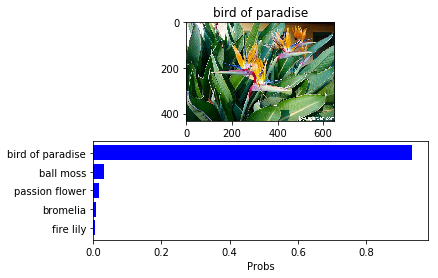

In [14]:
# Display an image along with the top 5 classes

sample_img = "../../assets/bird_of_paradise_sample.jpg"

probs, classes = predict(sample_img, model)
labels = [cat_to_name[x] for x in classes]

print(probs)
print(classes)
print(labels)
print(list(zip(labels, probs)))

# Display an image along with the top 5 classes
img = mpimg.imread(sample_img)

f, axarr = plt.subplots(2,1)

axarr[0].imshow(img)
axarr[0].set_title('bird of paradise')

y_pos = np.arange(len(classes))

axarr[1].barh(y_pos, probs, align='center', color='blue')
axarr[1].set_yticks(y_pos)
axarr[1].set_yticklabels(labels)
axarr[1].invert_yaxis()  # labels read top-to-bottom
_ = axarr[1].set_xlabel('Probs')

## Command line application

Now that you've built and trained a deep neural network on the flower data set, you can convert it into an application that others can use. Your application should be a pair of Python scripts that run from the command line. For testing, you could use the checkpoint you saved in the first part.

### Train

You can train a new network on a data set with `train.py`

Basic usage: `python train.py data_directory`

Options:
 - set directory to save checkpoints: `python train.py data_dir --checkpoint checkpoint_file_path`
 - choose architecture: `python train.py data_dir --arch "vgg13"`
 - set hyperparameters: `python train.py data_dir --learning_rate 0.01 --hidden_units 512 --epochs 20`
 - use GPU for training: `python train.py data_dir --gpu`

In [15]:
! python scripts/train.py -h

usage: train.py [-h] [--hidden_units HIDDEN_UNITS] [--arch ARCH]
                [--epochs EPOCHS] [--learning_rate LEARNING_RATE] [--gpu]
                [--checkpoint CHECKPOINT]
                data_dir

positional arguments:
  data_dir              Path to dataset

optional arguments:
  -h, --help            show this help message and exit
  --hidden_units HIDDEN_UNITS
                        Number of hidden units
  --arch ARCH           Model architecture
  --epochs EPOCHS       Number of epochs
  --learning_rate LEARNING_RATE
                        Learning rate
  --gpu                 Use GPU if available
  --checkpoint CHECKPOINT
                        Save trained model checkpoint to file


In [16]:
! python scripts/train.py ../../data/flowers --checkpoint ../../output/model.pth --arch alexnet --hidden_units 1024 --learning_rate 0.01 --epochs 2

Network architecture: alexnet
Number of hidden units: 1024
Number of epochs: 2
Learning rate: 0.01
Using: CPU

Epoch 1/2
train Loss: 4.4872 Accuracy: 0.1132
valid Loss: 4.5779 Accuracy: 0.1064

Epoch 2/2
train Loss: 4.5677 Accuracy: 0.0472
valid Loss: 4.4453 Accuracy: 0.0379

Training completed in 10m 6s
Best Accuracy: 0.106357
Saving checkpoint to: ../../output/model.pth


### Predict

Predict flower name from an image with `predict.py` along with the probability of that name. That is, you'll pass in a single image /path/to/image and return the flower name and class probability.

Basic usage: `python predict.py /path/to/image checkpoint`

Options:
 - return top KK most likely classes: `python predict.py input checkpoint --top_k 3`
 - use a mapping of categories to real names: `python predict.py input checkpoint --category_names cat_to_name.json`
 - use GPU for inference: `python predict.py input checkpoint --gpu`

In [17]:
! python scripts/predict.py -h

usage: predict.py [-h] [--category_names CATEGORY_NAMES] [--top_k TOP_K]
                  [--gpu]
                  image_path checkpoint

positional arguments:
  image_path            Image to predict
  checkpoint            Model checkpoint to use when predicting

optional arguments:
  -h, --help            show this help message and exit
  --category_names CATEGORY_NAMES
                        JSON file containing category names
  --top_k TOP_K         Return top K predictions
  --gpu                 Use GPU if available


In [18]:
! python scripts/predict.py ../../assets/bird_of_paradise_sample.jpg ../../output/model.pth \
    --category_names ../../data/cat_to_name.json

[('passion flower', 0.29349256), ('spring crocus', 0.26019049), ('great masterwort', 0.17028153), ('camellia', 0.15447263), ('petunia', 0.12156274)]
